In [337]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, CuDNNLSTM, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint

from math import sqrt
from sklearn.metrics import mean_squared_error

from fredapi import Fred
fred = Fred(fred_key)

from qreit.models.api_config import *
fred_key = fred_API

import time

import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


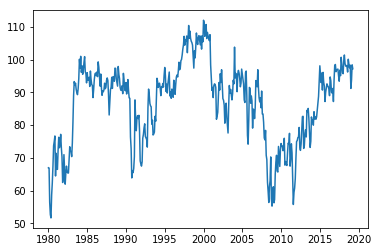

In [55]:
UMCSENT_df = fred.get_series('UMCSENT').to_frame()
UMCSENT_df.columns = ['UMCSENT']
UMCSENT_80_df = UMCSENT_df[UMCSENT_df.index >= '1980-01']

plt.plot(UMCSENT_80_df)
plt.show()

In [56]:
UMCSENT_80_df['UMCSENT_1'] = UMCSENT_80_df.shift(-1)
UMCSENT_80_df.dropna(inplace=True)

/Users/marktblack/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/marktblack/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [192]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()

UMCSENT_80_X_scaled = scaler.fit_transform(UMCSENT_80_df['UMCSENT'].to_frame())
UMCSENT_80_y_scaled = scaler.fit_transform(UMCSENT_80_df['UMCSENT_1'].to_frame())

In [449]:
test = int(len(UMCSENT_80_X_scaled)*0.90)

X_train_scaled = UMCSENT_80_X_scaled[:test]
y_train_scaled = UMCSENT_80_y_scaled[:test]
y_train = UMCSENT_80_df['UMCSENT_1'][:test]

X_test_scaled = UMCSENT_80_X_scaled[test:]
y_test_scaled = UMCSENT_80_y_scaled[test:]
y_test = UMCSENT_80_df['UMCSENT_1'][test:]

In [450]:
X_train = np.reshape(X_train_scaled, 
                     (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
# y_train = np.reshape(y_train_scaled, 
#                      (y_train_scaled.shape[0], 1, y_train_scaled.shape[1]))

X_test = np.reshape(X_test_scaled, 
                    (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
# y_test = np.reshape(y_test_scaled, 
#                     (y_test_scaled.shape[0], 1, y_test_scaled.shape[1]))

In [451]:
n_lookback = 1

In [452]:
# model = Sequential()
# model.add(LSTM(128, input_shape=(n_lookback,X_train.shape[2]), 
#                activation='relu', return_sequences=True))
# # model.add(Dropout(0.2))
# # model.add(BatchNormalization())  #normalizes activation outputs, same reason you want to normalize your input data.

# model.add(LSTM(128, activation='relu', return_sequences=True))
# model.add(Dropout(0.1))
# model.add(BatchNormalization())

# model.add(LSTM(128, activation='relu'))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())

# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.2))

# model.add(Dense(1, activation='softmax'))

# model.compile(loss='mae', optimizer='RMSprop')

In [453]:
model = Sequential()
model.add(LSTM(60, dropout=0.1, recurrent_dropout=0.2, return_sequences=True,
              input_shape=(n_lookback, X_train.shape[2])))
# model.add(Dropout(0.2))

model.add(LSTM(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(X_train.shape[2]))

# opt = tf.keras.optimizers.RMSprop(lr=0.001)

model.compile(loss='mean_squared_error', optimizer='RMSprop', metrics=['mae'])

In [454]:
def rnn_hyperparameter_tune(X_train, y_train_scaled, n_epochs, batchSize):
    model.fit(X_train, 
              y_train_scaled, 
              epochs=n_epochs,
              batch_size=batchSize, 
              verbose=0,
              shuffle=False)
    
    yhat_scale = model.predict(X_test)
    
    y_hat_inv_scaled = scaler.inverse_transform(yhat_scale)
    temp_root_sq_mu_err = sqrt(mean_squared_error(y_test.values, y_hat_inv_scaled))
    temp_root_sq_mu_err_per = round(sqrt(mean_squared_error(y_test.values, y_hat_inv_scaled))/y_test.values.mean()*100,4)
    
    print(f'# of Epochs, Batch Size: {n_epochs}, {batchSize}')
    print('Test RMSE: %.3f' % temp_root_sq_mu_err)
    print(f'RMSE %: {temp_root_sq_mu_err_per}%\n')
    
    return temp_root_sq_mu_err

In [455]:
root_sq_mu_err_ls = []

for epochs in range(100, 500, 100):
    root_sq_mu_err_ls.append(rnn_hyperparameter_tune(X_train, y_train_scaled, epochs, 40))

# of Epochs, Batch Size: 100, 40
Test RMSE: 3.023
RMSE %: 3.1843%

# of Epochs, Batch Size: 200, 40
Test RMSE: 2.806
RMSE %: 2.9554%

# of Epochs, Batch Size: 300, 40
Test RMSE: 2.861
RMSE %: 3.0131%

# of Epochs, Batch Size: 400, 40
Test RMSE: 2.863
RMSE %: 3.0154%



In [456]:
N_EPOCHS = 200
batchSize = 40

model.fit(X_train, 
          y_train_scaled, 
          epochs=N_EPOCHS,
          batch_size=batchSize, 
          verbose=0,
          shuffle=False)


In [430]:
tensorboard = TensorBoard(log_dir="logs/{}".format('test'))

In [433]:
yhat_scale = model.predict(X_test)
# yhat_scale

In [434]:
inv_yhat = np.concatenate((X_test_scaled, yhat_scale), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)

In [435]:
y_hat_inv_scaled = scaler.inverse_transform(yhat_scale)
preds_actuals_df = pd.DataFrame(y_test.values, 
                                y_hat_inv_scaled.flatten()).reset_index(drop=False)
preds_actuals_df.columns = ['preds', 'actual']
preds_actuals_df.assign(diff=preds_actuals_df.preds-preds_actuals_df.actual)


,preds,actual,diff
0,95.767189,97.1,-1.332811
1,95.842339,95.0,0.842339
2,94.288483,93.4,0.888483
3,93.162239,96.8,-3.637761
4,95.617210,95.1,0.517210
5,94.361275,100.7,-6.338725
6,98.618210,98.5,0.118210
7,96.906059,95.9,1.006059
8,94.948036,95.7,-0.751964
9,94.800621,99.7,-4.899379


In [436]:
y_hat_inv_scaled

array([[95.76719 ],
       [95.84234 ],
       [94.28848 ],
       [93.16224 ],
       [95.61721 ],
       [94.361275],
       [98.61821 ],
       [96.90606 ],
       [94.94804 ],
       [94.80062 ],
       [97.83412 ],
       [99.17249 ],
       [97.13671 ],
       [96.523735],
       [96.676346],
       [96.447586],
       [95.170044],
       [98.14663 ],
       [96.982834],
       [96.14408 ],
       [96.75281 ],
       [91.80088 ],
       [93.42468 ],
       [96.829384]], dtype=float32)

In [437]:
from math import sqrt
from sklearn.metrics import mean_squared_error

print('Test RMSE: %.3f' % sqrt(mean_squared_error(y_test.values,
                                                 y_hat_inv_scaled)))
print(f'RMSE %: {round(sqrt(mean_squared_error(y_test.values, y_hat_inv_scaled))/y_test.values.mean()*100,4)}%')

Test RMSE: 2.811
RMSE %: 2.8913%


### beer

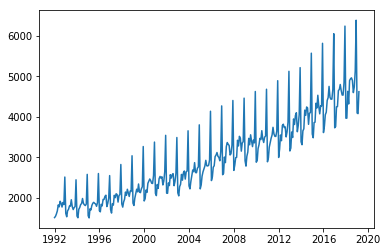

In [501]:
beer_df = fred.get_series('MRTSSM4453USN').to_frame()
beer_df.columns = ['beer']
beer_df = beer_df[beer_df.index >= '1980-01']
beer_df['beer_1'] = beer_df.shift(-1)
plt.plot(beer_df['beer'])
plt.show()

In [502]:
beer_UMCSENT_df = pd.merge(beer_df, UMCSENT_80_df, 
                            how='left', right_index=True, left_index=True).dropna()

In [762]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()

beer_UMCSENT_X_scaled = scaler.fit_transform(beer_UMCSENT_df[['beer', 'UMCSENT']])
beer_UMCSENT_y_scaled = scaler.fit_transform(beer_UMCSENT_df[['UMCSENT_1']])

In [763]:
test = int(len(beer_UMCSENT_X_scaled)*0.95)

X_train_scaled = beer_UMCSENT_X_scaled[:test]
y_train_scaled = beer_UMCSENT_y_scaled[:test]
y_train = beer_UMCSENT_df[['beer_1','UMCSENT_1']][:test]

X_test_scaled = beer_UMCSENT_X_scaled[test:]
y_test_scaled = beer_UMCSENT_y_scaled[test:]
y_test = beer_UMCSENT_df[['UMCSENT_1']][test:]

In [764]:
X_train = np.reshape(X_train_scaled, 
                     (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))

X_test = np.reshape(X_test_scaled, 
                    (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [765]:
model = Sequential()
model.add(LSTM(60, dropout=0.1, recurrent_dropout=0.2, return_sequences=True,
              input_shape=(n_lookback, X_train.shape[2]),  activation='relu'))
model.add(Dropout(0.2))

model.add(LSTM(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(X_train.shape[1]))

# opt = tf.keras.optimizers.RMSprop(lr=0.001)

model.compile(loss='mean_squared_error', optimizer='RMSprop', metrics=['mae'])

In [766]:
N_EPOCHS =100
batchSize = 40

model.fit(X_train, 
          y_train_scaled, 
          epochs=N_EPOCHS,
          batch_size=batchSize, 
          verbose=1,
          shuffle=False)

Epoch 1/100
309/309 [==============================] - 16s 53ms/step - loss: 1.0067 - mean_absolute_error: 0.8024
Epoch 2/100
309/309 [==============================] - 0s 182us/step - loss: 0.9906 - mean_absolute_error: 0.7956
Epoch 3/100
309/309 [==============================] - 0s 162us/step - loss: 0.9822 - mean_absolute_error: 0.7913
Epoch 4/100
309/309 [==============================] - 0s 171us/step - loss: 0.9713 - mean_absolute_error: 0.7875
Epoch 5/100
309/309 [==============================] - 0s 166us/step - loss: 0.9573 - mean_absolute_error: 0.7810
Epoch 6/100
309/309 [==============================] - 0s 162us/step - loss: 0.9400 - mean_absolute_error: 0.7735
Epoch 7/100
309/309 [==============================] - 0s 162us/step - loss: 0.9218 - mean_absolute_error: 0.7654
Epoch 8/100
309/309 [==============================] - 0s 161us/step - loss: 0.9074 - mean_absolute_error: 0.7567
Epoch 9/100
309/309 [==============================] - 0s 154us/step - loss: 0.8766 - me

309/309 [==============================] - 0s 165us/step - loss: 0.2054 - mean_absolute_error: 0.3255
Epoch 73/100
309/309 [==============================] - 0s 178us/step - loss: 0.1931 - mean_absolute_error: 0.3241
Epoch 74/100
309/309 [==============================] - 0s 191us/step - loss: 0.1961 - mean_absolute_error: 0.3249
Epoch 75/100
309/309 [==============================] - 0s 196us/step - loss: 0.1791 - mean_absolute_error: 0.3001
Epoch 76/100
309/309 [==============================] - 0s 178us/step - loss: 0.2164 - mean_absolute_error: 0.3251
Epoch 77/100
309/309 [==============================] - 0s 181us/step - loss: 0.1725 - mean_absolute_error: 0.3063
Epoch 78/100
309/309 [==============================] - 0s 158us/step - loss: 0.1712 - mean_absolute_error: 0.3099
Epoch 79/100
309/309 [==============================] - 0s 173us/step - loss: 0.2275 - mean_absolute_error: 0.3375
Epoch 80/100
309/309 [==============================] - 0s 178us/step - loss: 0.1664 - mean_a

In [767]:
yhat_scale = model.predict(X_test)
# yhat_scale

In [768]:
# inv_yhat = np.concatenate((X_test_scaled, yhat_scale), axis=1)
inv_yhat = scaler.inverse_transform(yhat_scale)

In [769]:
y_hat_inv_scaled = scaler.inverse_transform(yhat_scale)
preds_df = pd.DataFrame(y_hat_inv_scaled, columns=['UMCSENT_preds'])

In [770]:
# y_test = y_test.assign(beer_preds=preds_df['beer_preds'].values)
y_test['UMCSENT_preds'] = preds_df['UMCSENT_preds'].values

# beer_preds_actual_df = y_test[['beer_1', 'beer_preds']]
UMCSENT_preds_actual_df = y_test[['UMCSENT_1', 'UMCSENT_preds']]

# beer_preds_actual_df = beer_preds_actual_df.assign(beer_diff=(beer_preds_actual_df.beer_preds-\
#                                                   beer_preds_actual_df.beer_1))
UMCSENT_preds_actual_df = UMCSENT_preds_actual_df.assign(UMCSENT_diff=(UMCSENT_preds_actual_df.UMCSENT_preds-\
                                                          UMCSENT_preds_actual_df.UMCSENT_1))


In [761]:
# print('Test RMSE: %.3f' % sqrt(mean_squared_error(beer_preds_actual_df.beer_1,
#                                                  beer_preds_actual_df.beer_preds)))
# print(f'RMSE %: {round(sqrt(mean_squared_error(beer_preds_actual_df.beer_1, beer_preds_actual_df.beer_preds))/beer_preds_actual_df.beer_1.mean()*100,4)}%')

Test RMSE: 633.052
RMSE %: 13.2366%


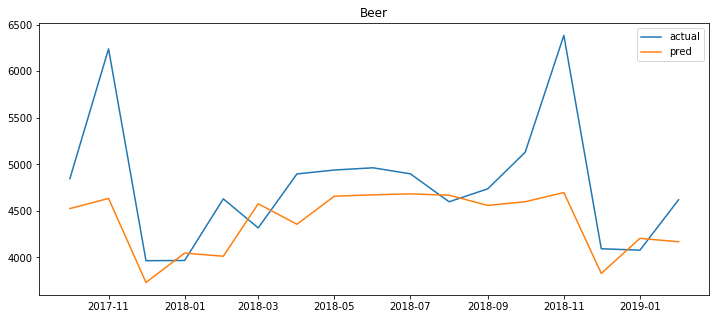

In [755]:
# plt.figure(figsize=(12,5))
# plt.plot(beer_preds_actual_df.beer_1, label='actual')
# plt.plot(beer_preds_actual_df.beer_preds, label='pred')
# plt.title(f'Beer')
# plt.legend()
# plt.show()

In [771]:
print('Test RMSE: %.3f' % sqrt(mean_squared_error(UMCSENT_preds_actual_df.UMCSENT_1,
                                                 UMCSENT_preds_actual_df.UMCSENT_preds)))
print(f'RMSE %: {round(sqrt(mean_squared_error(UMCSENT_preds_actual_df.UMCSENT_1, UMCSENT_preds_actual_df.UMCSENT_preds))/UMCSENT_preds_actual_df.UMCSENT_1.mean()*100,4)}%')


Test RMSE: 3.302
RMSE %: 3.3855%


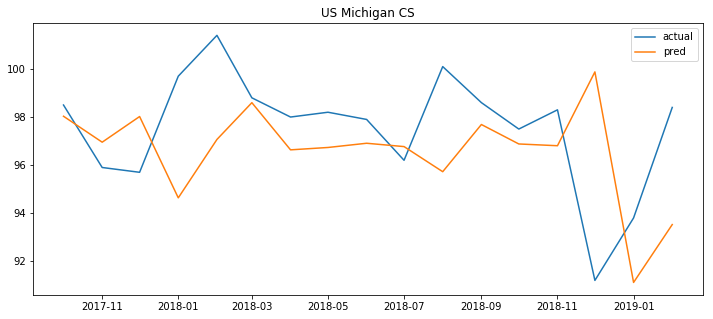

In [772]:
plt.figure(figsize=(12,5))
plt.plot(UMCSENT_preds_actual_df.UMCSENT_1, label='actual')
plt.plot(UMCSENT_preds_actual_df.UMCSENT_preds, label='pred')
plt.title(f'US Michigan CS')
plt.legend()
plt.show()

### Keras

In [691]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM

In [718]:
def keras_lstm(x_train, y_train_scaled, X_test, 
               N_EPOCHS, batchSize, neuron_1):
    model = Sequential()
    model.add(LSTM(neuron_1, 
                   batch_input_shape=(batchSize, x_train.shape[1], x_train.shape[2]), 
                   stateful=True, activation='relu'))
    model.add(Dropout(0.2))
#     model.add(LSTM(neuron_2, activation='relu'))
#     model.add(Dropout(0.1))    
    model.add(Dense(X_train.shape[2]))
    
    model.compile(loss='mean_squared_error', optimizer='RMSprop', metrics=['mae'])
    
    model.fit(X_train, y_train_scaled, 
              epochs=N_EPOCHS,
              batch_size=batchSize, 
              verbose=1,
              shuffle=False)
    yhat_scale = model.predict(X_test, batch_size=batchSize)
    return yhat_scale


In [719]:
yhat_scale_preds = keras_lstm(X_train, y_train_scaled, X_test, 50, 1, 1, )

Epoch 1/50
309/309 [==============================] - 15s 47ms/step - loss: 1.1867 - mean_absolute_error: 0.8868
Epoch 2/50
309/309 [==============================] - 1s 4ms/step - loss: 1.0183 - mean_absolute_error: 0.8280
Epoch 3/50
309/309 [==============================] - 1s 4ms/step - loss: 0.9558 - mean_absolute_error: 0.7997
Epoch 4/50
309/309 [==============================] - 1s 3ms/step - loss: 0.9408 - mean_absolute_error: 0.7910
Epoch 5/50
309/309 [==============================] - 1s 3ms/step - loss: 0.9357 - mean_absolute_error: 0.7874
Epoch 6/50
309/309 [==============================] - 1s 3ms/step - loss: 0.9344 - mean_absolute_error: 0.7871
Epoch 7/50
309/309 [==============================] - 1s 4ms/step - loss: 0.9331 - mean_absolute_error: 0.7855A: 0s - loss: 0.8917 - mean_absolute_error: 0.
Epoch 8/50
309/309 [==============================] - 1s 4ms/step - loss: 0.9307 - mean_absolute_error: 0.7843
Epoch 9/50
309/309 [==============================] - 1s 4ms/ste

In [720]:
def inverse_scale(inv_preds):
    return scaler.inverse_transform(inv_preds)

In [721]:
inverse_scale(yhat_scale_preds)

array([[2838.8477  ,   92.33181 ],
       [2915.2485  ,   89.843605],
       [2986.9395  ,   87.5088  ],
       [2832.9143  ,   92.52504 ],
       [2815.6052  ,   93.08876 ],
       [2807.972   ,   93.33736 ],
       [2800.0024  ,   93.59691 ],
       [2855.7466  ,   91.78145 ],
       [2819.383   ,   92.96572 ],
       [2846.362   ,   92.087074],
       [2853.4177  ,   91.85729 ],
       [2735.2383  ,   95.70612 ],
       [2837.847   ,   92.364395],
       [2822.1768  ,   92.87474 ],
       [2921.783   ,   89.63079 ],
       [2814.3284  ,   93.13034 ],
       [2839.165   ,   92.32147 ]], dtype=float32)